In [1]:
import mne 
mne.set_log_level('error')

p_id = 'sub-001'
data_dir = 'data/' + p_id + '/'

raw_filt = mne.io.read_raw_fif(data_dir + p_id + '-filt-raw-arg.fif')
raw_filt.set_montage('easycap-M1')

Measurement date,"January 20, 2015 13:15:58 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


getting event codes and event labels from the continuous time filtered data

In [2]:
events, events_dict = mne.events_from_annotations(raw_filt)

In [3]:
print(events[0:10])
print([key for key in events_dict if events_dict[key] in events[0:10,2]])
print([key for key in events_dict if events_dict[key] == 7])
print(events_dict)



[[    0     0     2]
 [    0     0     1]
 [25550     0     7]
 [25553     0     3]
 [26099     0    13]
 [26144     0     4]
 [29582     0     5]
 [33283     0     3]
 [33781     0    15]
 [34932     0     5]]
[np.str_('Comment/actiCAP Data On'), np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S201'), np.str_('Stimulus/S211')]
[np.str_('Stimulus/S  5')]
{np.str_('Comment/actiCAP Data On'): 1, np.str_('New Segment/'): 2, np.str_('Stimulus/S  1'): 3, np.str_('Stimulus/S  2'): 4, np.str_('Stimulus/S  3'): 5, np.str_('Stimulus/S  4'): 6, np.str_('Stimulus/S  5'): 7, np.str_('Stimulus/S  7'): 8, np.str_('Stimulus/S101'): 9, np.str_('Stimulus/S102'): 10, np.str_('Stimulus/S111'): 11, np.str_('Stimulus/S112'): 12, np.str_('Stimulus/S201'): 13, np.str_('Stimulus/S202'): 14, np.str_('Stimulus/S211'): 15, np.str_('Stimulus/S212'): 16}


BRainvision format raw data file saves event codes in their original format so extracting event data and codes from raw file

In [4]:
raw = mne.io.read_raw_brainvision(data_dir + p_id + '.vhdr',preload=False)

events_raw,events_raw_dict = mne.events_from_annotations(raw)

print(events_raw[:10])
print([(key, events_raw_dict[key]) for key in events_raw_dict if events_raw_dict[key] in events_raw[0:10,2]])
print(events_raw_dict)



[[    0     0 99999]
 [    0     0 10001]
 [25550     0     5]
 [25553     0     1]
 [26099     0   201]
 [26144     0     2]
 [29582     0     3]
 [33283     0     1]
 [33781     0   211]
 [34932     0     3]]
[(np.str_('Comment/actiCAP Data On'), 10001), (np.str_('New Segment/'), 99999), (np.str_('Stimulus/S  1'), 1), (np.str_('Stimulus/S  2'), 2), (np.str_('Stimulus/S  3'), 3), (np.str_('Stimulus/S  5'), 5), (np.str_('Stimulus/S201'), 201), (np.str_('Stimulus/S211'), 211)]
{np.str_('Comment/actiCAP Data On'): 10001, np.str_('New Segment/'): 99999, np.str_('Stimulus/S  1'): 1, np.str_('Stimulus/S  2'): 2, np.str_('Stimulus/S  3'): 3, np.str_('Stimulus/S  4'): 4, np.str_('Stimulus/S  5'): 5, np.str_('Stimulus/S  7'): 7, np.str_('Stimulus/S101'): 101, np.str_('Stimulus/S102'): 102, np.str_('Stimulus/S111'): 111, np.str_('Stimulus/S112'): 112, np.str_('Stimulus/S201'): 201, np.str_('Stimulus/S202'): 202, np.str_('Stimulus/S211'): 211, np.str_('Stimulus/S212'): 212}


event labels with event codes


In [5]:
event_mapping = {'PicOnset':1, 'RespPrompt':2, 'CorResp':3, 'IncorResp':4, 'RespFeedback':5, 'unused':7,          
                 'Match/A':111, 'Match/B':211, 'Match/C':112, 'Match/D':212,
                 'Mismatch/A':101, 'Mismatch/B':201, 'Mismatch/C':102, 'Mismatch/D':202
                }

#swapping keys and values to match with codes extracted from events data
event_mapping = {v:k for k,v in event_mapping.items()}
print(event_mapping)

{1: 'PicOnset', 2: 'RespPrompt', 3: 'CorResp', 4: 'IncorResp', 5: 'RespFeedback', 7: 'unused', 111: 'Match/A', 211: 'Match/B', 112: 'Match/C', 212: 'Match/D', 101: 'Mismatch/A', 201: 'Mismatch/B', 102: 'Mismatch/C', 202: 'Mismatch/D'}


In [6]:
events_id ={}
for key in events_dict.keys():
    if ('Stimulus/S' in key):
        mapping_key = int(key.split('/')[1].split('S')[1].strip())
        label = event_mapping[mapping_key]
        events_id[label] = events_dict[key]
print(events_id)

{'PicOnset': 3, 'RespPrompt': 4, 'CorResp': 5, 'IncorResp': 6, 'RespFeedback': 7, 'unused': 8, 'Mismatch/A': 9, 'Mismatch/C': 10, 'Match/A': 11, 'Match/C': 12, 'Mismatch/B': 13, 'Mismatch/D': 14, 'Match/B': 15, 'Match/D': 16}


plotting the event labels on timeline 

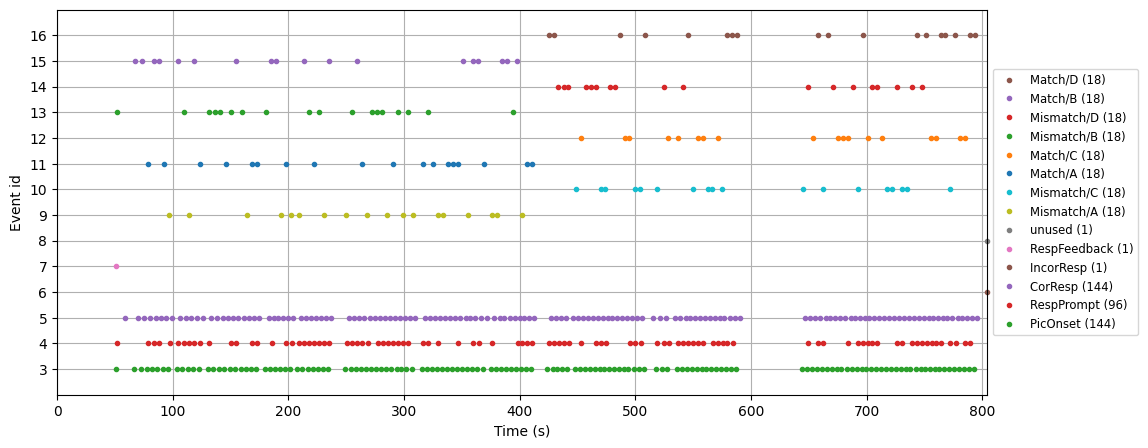

In [7]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=[15,5])

mne.viz.plot_events(events,raw_filt.info['sfreq'],
             event_id=events_id,show=False,axes=ax)
plt.show()



creating epochs with baseline of .1 sec i.e. 100 ms from start of epoch to onset of event 

In [8]:
tmin= -.100
tmax = 1.00
baseline = (None,0)

epochs = mne.Epochs(raw_filt,events,events_id,tmin=tmin,tmax=tmax,baseline=baseline,preload=True)

In [9]:
epochs

Number of events,531
Events,CorResp: 144IncorResp: 1Match/A: 18Match/B: 18Match/C: 18Match/D: 18Mismatch/A: 18Mismatch/B: 18Mismatch/C: 18Mismatch/D: 18PicOnset: 144RespFeedback: 1RespPrompt: 96unused: 1
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


In [10]:
epochs[0]

Number of events,1
Events,RespFeedback: 1
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


In [11]:
epochs[10:15]


Number of events,5
Events,CorResp: 2Match/A: 1PicOnset: 1RespPrompt: 1
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


In [12]:
epochs['A']

Number of events,36
Events,Match/A: 18Mismatch/A: 18
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


In [13]:
epochs['Mismatch']

Number of events,72
Events,Mismatch/A: 18Mismatch/B: 18Mismatch/C: 18Mismatch/D: 18
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


visualising erp data averaged over all trials across conditions of interest

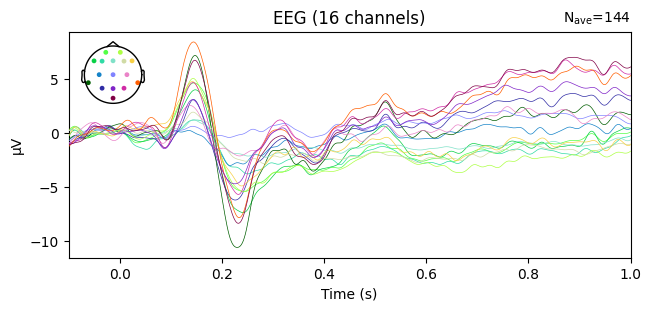

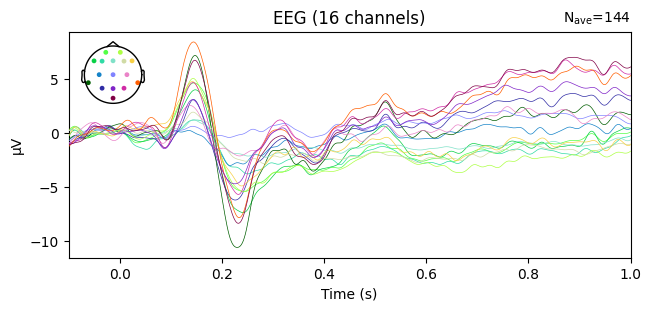

In [14]:
epochs['Mismatch','Match'].average().plot()

apply ica correction to epochs 

In [15]:
ica = mne.preprocessing.read_ica(data_dir + p_id + '-ica-arg.fif')

epochs_postica = ica.apply(epochs.copy())


visuaise epochs data after ica correction

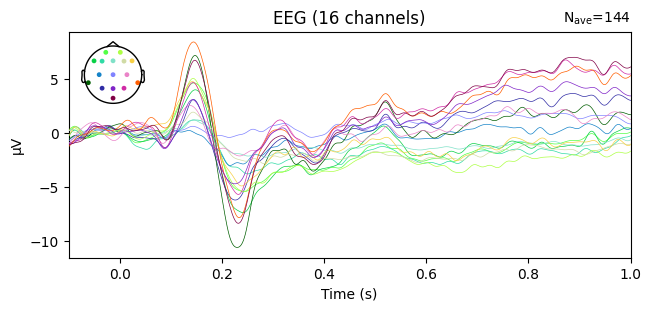

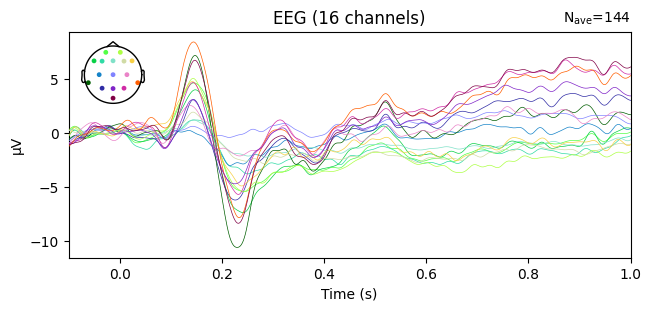

In [16]:
epochs_postica['Match','Mismatch'].average().plot(ylim=[-11,10])

running autoreject on ica data to remove large variance artefacts out 

In [20]:
from autoreject import AutoReject
ar = AutoReject(n_interpolate = [1,2,4],
                random_state = 42,
                picks = mne.pick_types(epochs.info, eeg=True, eog=True),
                verbose = True,
                n_jobs = 1)
epochs_clean,reject_log_clean = ar.fit_transform(epochs_postica,return_log=True)
epochs_clean


Running autoreject on ch_type=eeg


/home/arg/neuro/NESC_3505_textbook/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm






Estimated consensus=0.60 and n_interpolate=4


Number of events,516
Events,CorResp: 136IncorResp: 0Match/A: 18Match/B: 18Match/C: 18Match/D: 18Mismatch/A: 18Mismatch/B: 18Mismatch/C: 17Mismatch/D: 18PicOnset: 141RespFeedback: 1RespPrompt: 95unused: 0
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


plot to see which epochs were rejected and which were interpolated

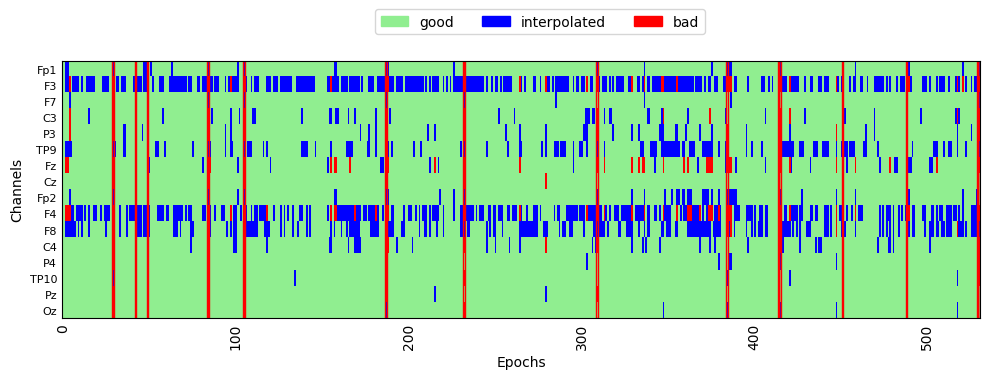

In [23]:
fig,ax = plt.subplots(figsize=[10,4])
reject_log_clean.plot('horizontal',aspect="auto",ax=ax)
plt.show()

plot average erp after autoreject

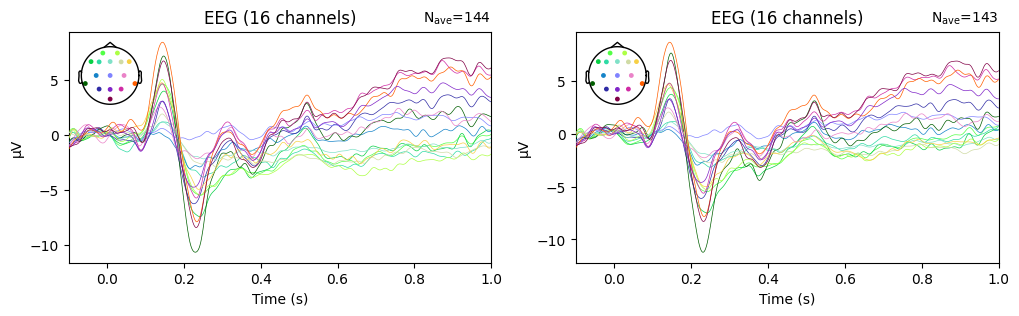

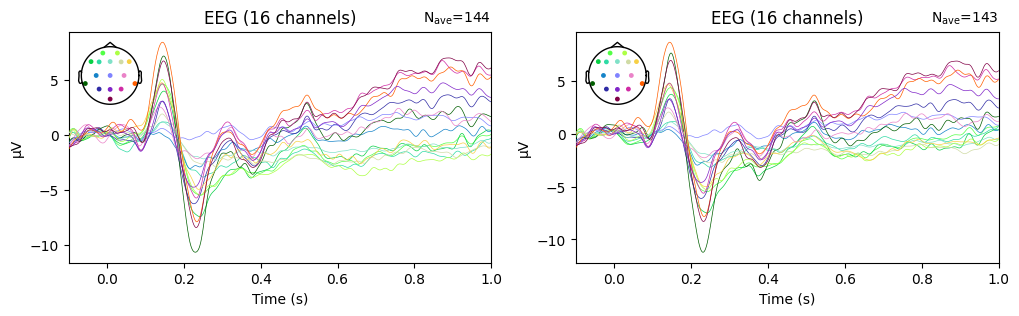

In [25]:
fig,ax = plt.subplots(1,2,figsize=[12,3])
epochs['Match','Mismatch'].average().plot(axes=ax[0],show=False)
epochs_clean['Match','Mismatch'].average().plot(axes=ax[1],show=False)
plt.show(0)

plotting autoreject corrected data in scalp topography maps


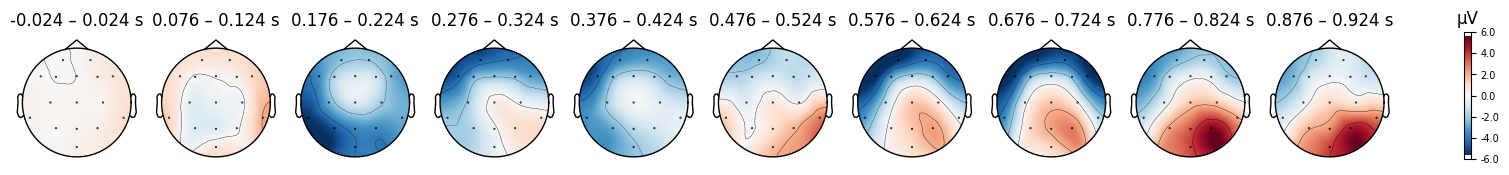

In [29]:
import numpy as np
times =np.arange(0,tmax,0.1)
epochs_clean['Match'].average().plot_topomap(times=times,average=0.050)

plt.show()


plotting scalp topo maps for averaged mismatches at 100ms gaps at 50ms averages on both sides


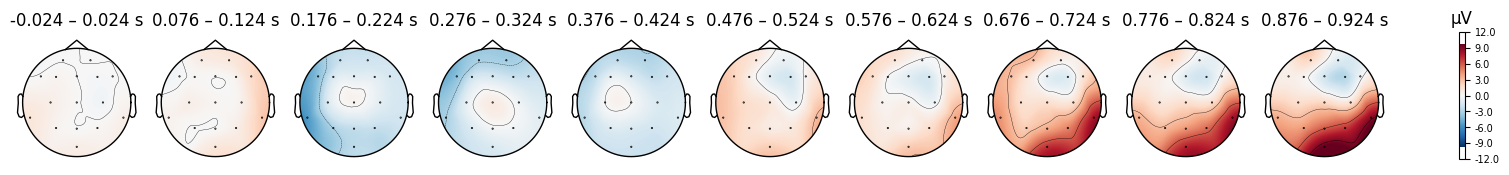

In [30]:
epochs_clean['Mismatch'].average().plot_topomap(times=times,average=0.050)

plt.show()

to compare matches and mismatches averaging over the same y range and colorbar range +-0.8mv

times = np.arange(0.tmax.0.1)

#plotting matches
epochs_clean["Match"].average().plot_topomap(times=times,average=0.050,vlim=(-0.8,0.8))

#plotting mismatches
print("Mismatch")

epochs_clean['Mismatch'].average().plot_topomap(times=times,average=0.050,vlim=(-0.8,0.8))


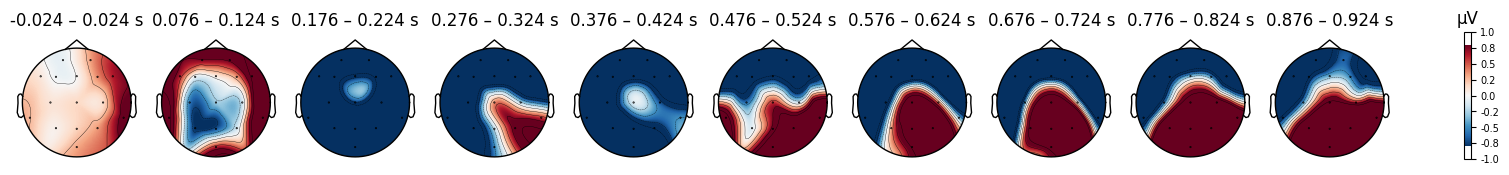

Mismatch


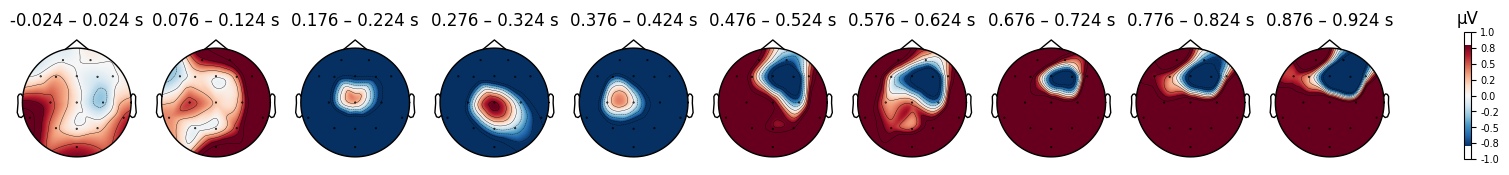

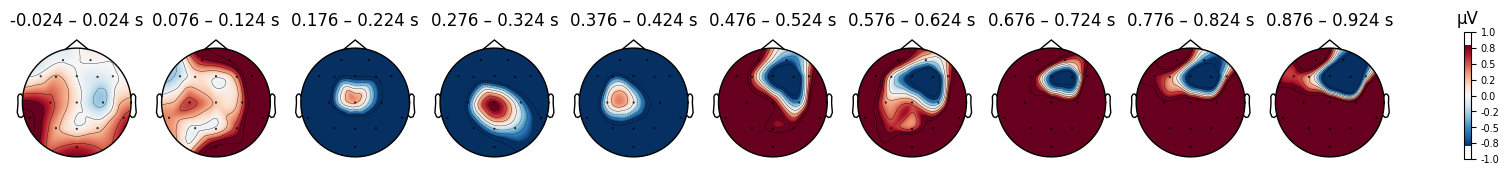

In [33]:
times = np.arange(0,tmax,0.1)

#plotting matches
epochs_clean["Match"].average().plot_topomap(times=times,average=0.050,vlim=(-0.8,0.8))

#plotting mismatches
print("Mismatch")

epochs_clean['Mismatch'].average().plot_topomap(times=times,average=0.050,vlim=(-0.8,0.8))

In [34]:
epochs_clean.save(data_dir+p_id+'-arg-epo.fif', overwrite=True)